In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

sns.set_context("talk")
sns.set_style("white")


In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']
model_name = mydict['model_name']

In [3]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def assessme(y_true, y_pred, printme=False):
    met = {}
    met['mae'] = mean_absolute_error(y_true, y_pred)
    met['mse'] = mean_squared_error(y_true, y_pred)
    met['rmse'] = np.sqrt(met['mse'])
    met['r2'] = r2_score(y_true, y_pred)
    n, k = len(y_true), 1
    met['adj_r2'] = 1 - (1 - met['r2']) * (n - 1) / (n - k - 1)
    if printme:
        print(f" MAE: {met['mae']}\n MSE: {met['mse']}\n RMSE: {met['rmse']}\n R²: {met['r2']}\n Adjusted R²: {met['adj_r2']}")
    return met

### semantic uncertainty (rao_s)

In [5]:
mm.run.max()

9

In [6]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [7]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

10

In [8]:
%%time

# take generated 
mmg = mm[mm.segment=='generated']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded], 
                 axis=1)

mmg.shape

CPU times: user 20.9 s, sys: 633 ms, total: 21.5 s
Wall time: 21.6 s


(375632, 59)

In [9]:
%%time

# take postilla
mmp = mm[mm.segment=='postilla']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded_postilla = mmp['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded_postilla.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded_postilla.shape[1])]

mmp = pd.concat([mmp.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded_postilla], 
                 axis=1)

mmp.shape

CPU times: user 4.67 s, sys: 93.9 ms, total: 4.76 s
Wall time: 4.76 s


(84189, 59)

In [10]:
%%time

# multiply fishes

runs = pd.DataFrame({"run": range(10)}) 
mmp = mmp.drop(columns=['run']) # only run 0
mmp_e = runs.merge(mmp, how="cross")

mmp_e.shape[0] == 10 * mmp.shape[0]

CPU times: user 92.4 ms, sys: 81.6 ms, total: 174 ms
Wall time: 175 ms


True

In [11]:
# reconstructed vectors for postilla and generated (half a GB)
mmg = pd.concat([mmg, mmp_e], axis=0).sort_values(["run", "pid", "tok"])

In [12]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

In [13]:
target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

In [14]:
ds

,run,pid,true_ent_0,true_ent_1,true_ent_2,true_ent_3,true_ent_4,true_ent_5,true_ent_6,true_ent_7,true_ent_8,true_ent_9,maxp_0,maxp_1,maxp_2,maxp_3,maxp_4,maxp_5,maxp_6,maxp_7,maxp_8,maxp_9,correct,hallucinated,pe_rao_trans_s_norm,correct_mean
0,0,0,0.56676,0.116919,0.359071,0.359680,0.000638,2.380402e-03,0.301823,2.926911e-03,1.021409e-02,0.000004,0.858375,0.981339,0.957001,0.937542,0.999951,0.999834,0.948011,0.999696,0.998981,1.000000,False,False,-2.220446e-16,0.0
1,1,0,0.56676,0.220961,0.215592,0.000676,0.001149,3.052162e-01,0.001925,7.532986e-03,1.006929e-06,0.000067,0.858375,0.972802,0.964329,0.999948,0.999920,0.945321,0.999807,0.999265,1.000000,0.999997,False,False,-2.220446e-16,0.0
2,2,0,0.56676,0.220961,0.215592,0.000676,0.001149,3.052162e-01,0.001925,7.532986e-03,1.006929e-06,0.000067,0.858375,0.972802,0.964329,0.999948,0.999920,0.945321,0.999807,0.999265,1.000000,0.999997,False,False,-2.220446e-16,0.0
3,3,0,0.56676,0.220961,0.215592,0.000676,0.001149,3.052162e-01,0.001925,7.532986e-03,1.006929e-06,0.000067,0.858375,0.972802,0.964329,0.999948,0.999920,0.945321,0.999807,0.999265,1.000000,0.999997,False,False,-2.220446e-16,0.0
4,4,0,0.56676,0.116919,0.359071,0.359680,0.000638,2.380402e-03,0.301823,2.926911e-03,1.021409e-02,0.000004,0.858375,0.981339,0.957001,0.937542,0.999951,0.999834,0.948011,0.999696,0.998981,1.000000,False,False,-2.220446e-16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14755,5,1800,0.50121,0.176352,0.205444,0.012710,0.000002,1.274874e-08,0.000003,7.140959e-08,2.263397e-08,0.001668,0.881826,0.976164,0.951401,0.998632,1.000000,1.000000,1.000000,1.000000,1.000000,0.999853,True,False,-0.000000e+00,1.0
14756,6,1800,0.50121,0.176352,0.205444,0.012710,0.000002,1.274874e-08,0.000003,7.140959e-08,2.263397e-08,0.001668,0.881826,0.976164,0.951401,0.998632,1.000000,1.000000,1.000000,1.000000,1.000000,0.999853,True,False,-0.000000e+00,1.0
14757,7,1800,0.50121,0.176352,0.205444,0.012710,0.000002,1.274874e-08,0.000003,7.140959e-08,2.263397e-08,0.001668,0.881826,0.976164,0.951401,0.998632,1.000000,1.000000,1.000000,1.000000,1.000000,0.999853,True,False,-0.000000e+00,1.0
14758,8,1800,0.50121,0.176352,0.205444,0.012710,0.000002,1.274874e-08,0.000003,7.140959e-08,2.263397e-08,0.001668,0.881826,0.976164,0.951401,0.998632,1.000000,1.000000,1.000000,1.000000,1.000000,0.999853,True,False,-0.000000e+00,1.0


In [15]:
ds.correct.value_counts()

correct
True     11233
False     3527
Name: count, dtype: int64

In [16]:
# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.dropna().drop_duplicates(ds.columns[1:-3])

In [17]:
y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

In [18]:
X.loc[:,X.nunique()!=1].shape

(3030, 20)

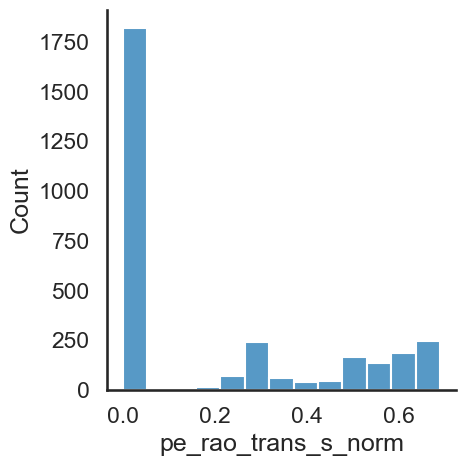

In [19]:
sns.displot(y)

In [20]:
X.isnull().sum().sum() == 0

True

In [21]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [22]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation, entropy

In [23]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 6.08 s, sys: 3.66 s, total: 9.74 s
Wall time: 2.55 s


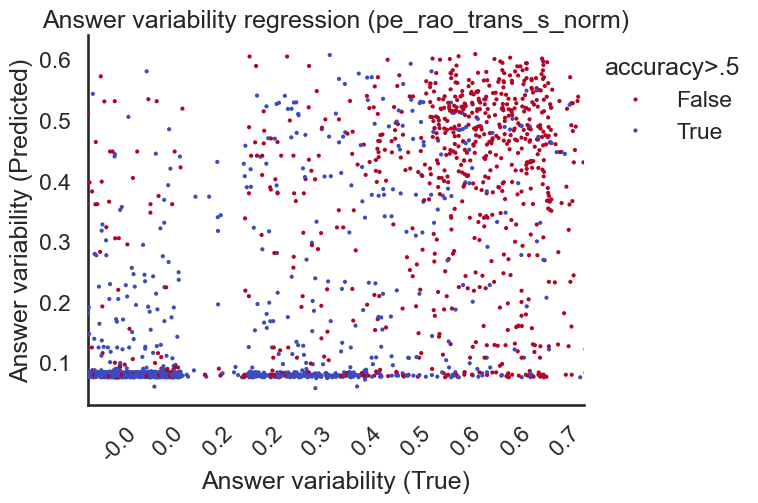

In [24]:
import matplotlib.colors as mcolors

norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean_thr, 
                   size=3, 
                   palette = palette)
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

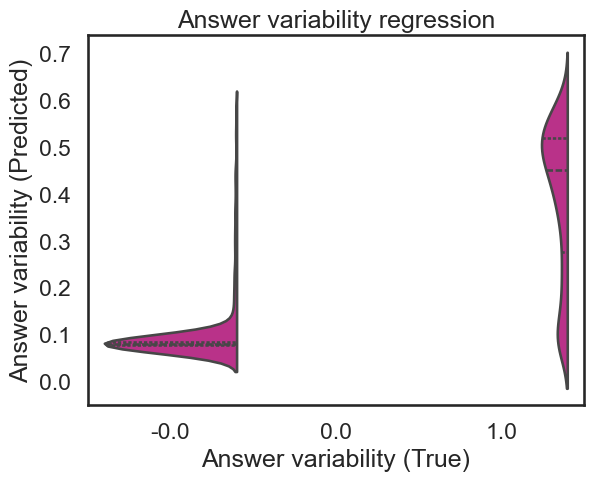

In [25]:
palette = Bold_10.mpl_colors

ax = sns.violinplot(y=pred, x=np.round(y_res.values,0), 
                    split=True, inner="quart", width=0.8, color=palette[8]) # , log_scale=(True,False))

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [26]:
met = assessme(y_res.values, pred)
met

{'mae': 0.14282615370964846,
 'mse': 0.03450688269798403,
 'rmse': 0.18576028288626184,
 'r2': 0.47026922400131344,
 'adj_r2': 0.47009427988770747}

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_6730/1641135401.py:3: RuntimeWarning: invalid value encountered in scalar divide
  unsure_count = [(~correct_mean_thr[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]


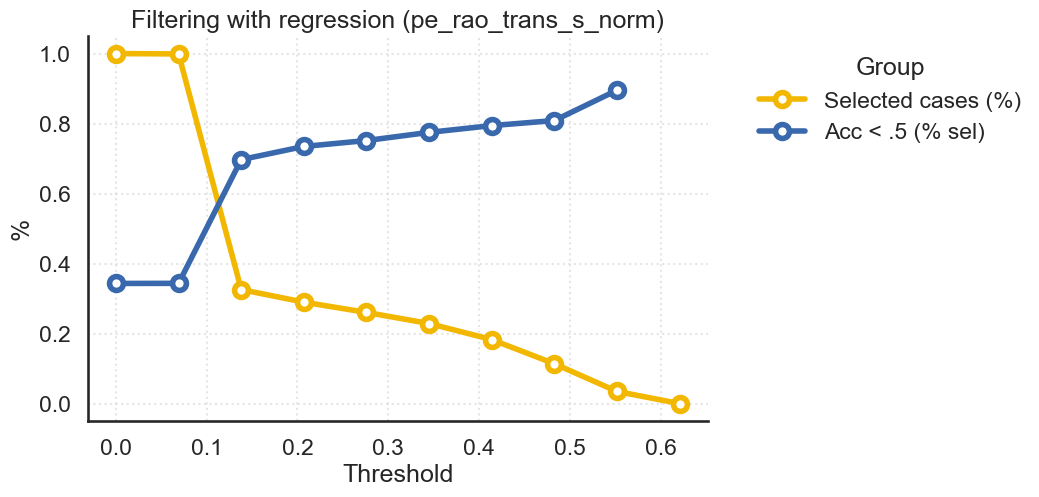

In [27]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

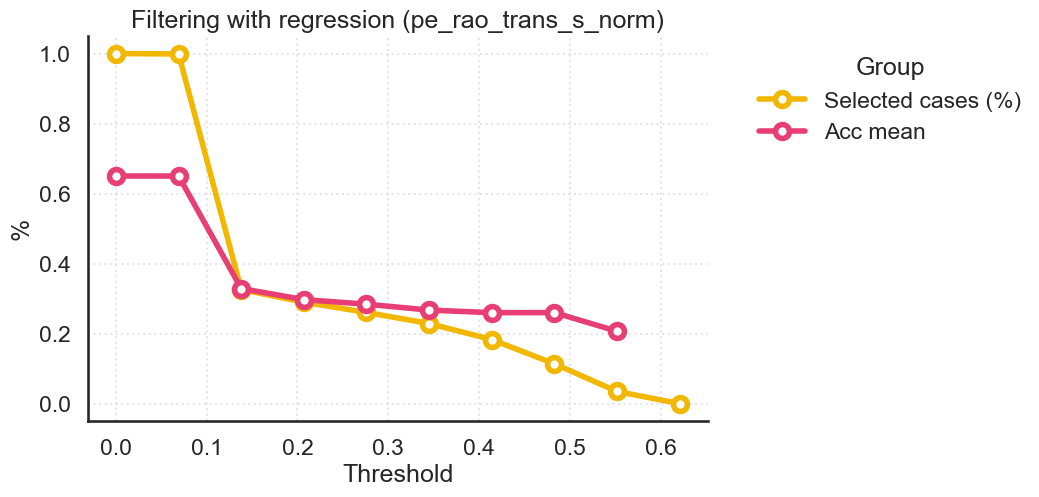

In [28]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [correct_mean[pred>=thr].mean() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc mean", marker="o", color=palette[4], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[4])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

### answers entropy

In [29]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

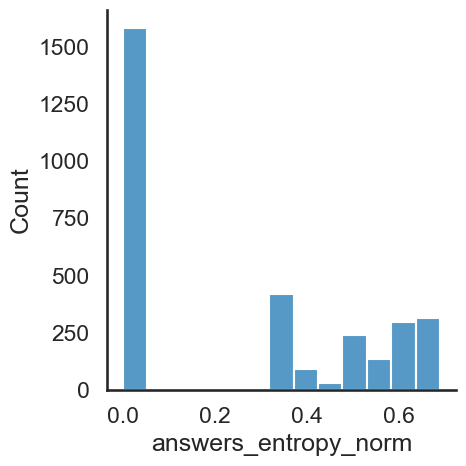

In [30]:
sns.displot(y)

In [31]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 9.12 s, sys: 6.18 s, total: 15.3 s
Wall time: 3.55 s


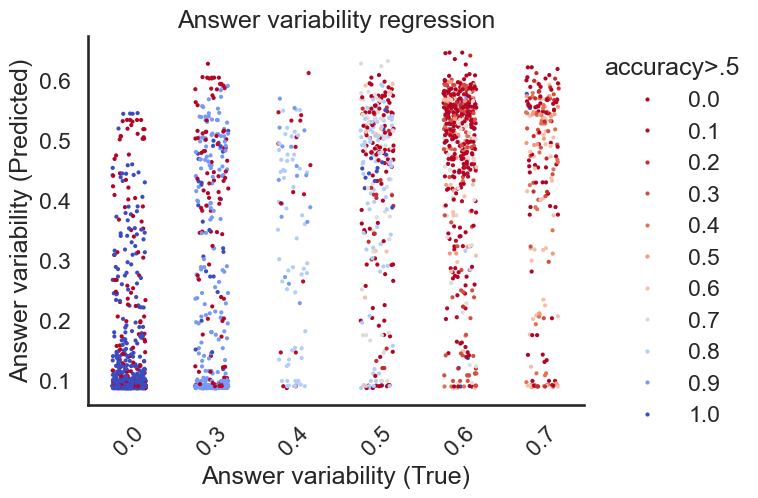

In [32]:
norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), jitter=0.2, hue=correct_mean, size=3, palette=palette) # , log_scale=(True,False))
sns.despine()

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

#from matplotlib.ticker import MaxNLocator
#ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [33]:
met = assessme(y_res.values, pred)
met

{'mae': 0.14185398983869416,
 'mse': 0.032765248245635946,
 'rmse': 0.1810117351047604,
 'r2': 0.5512658544822688,
 'adj_r2': 0.5511219371809482}

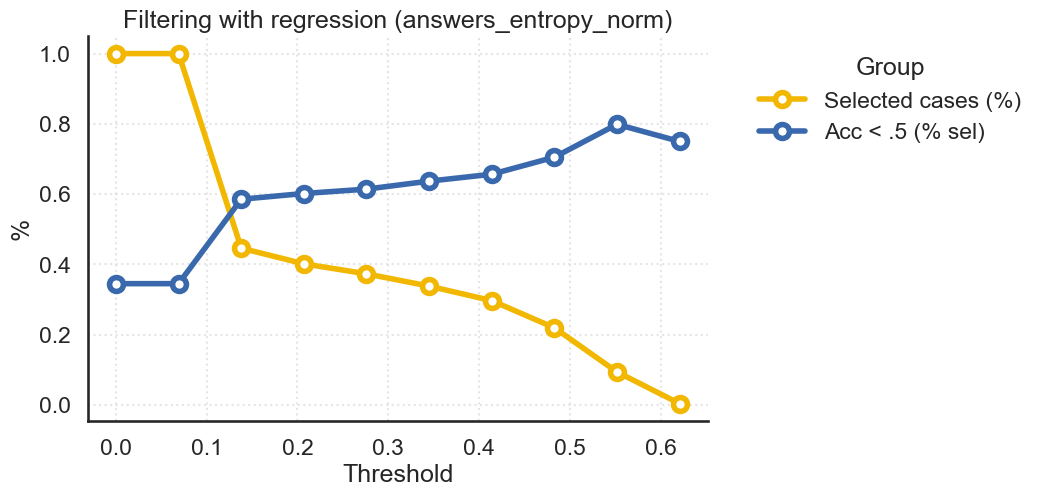

In [34]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred > thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>thr]).sum() / (pred>thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

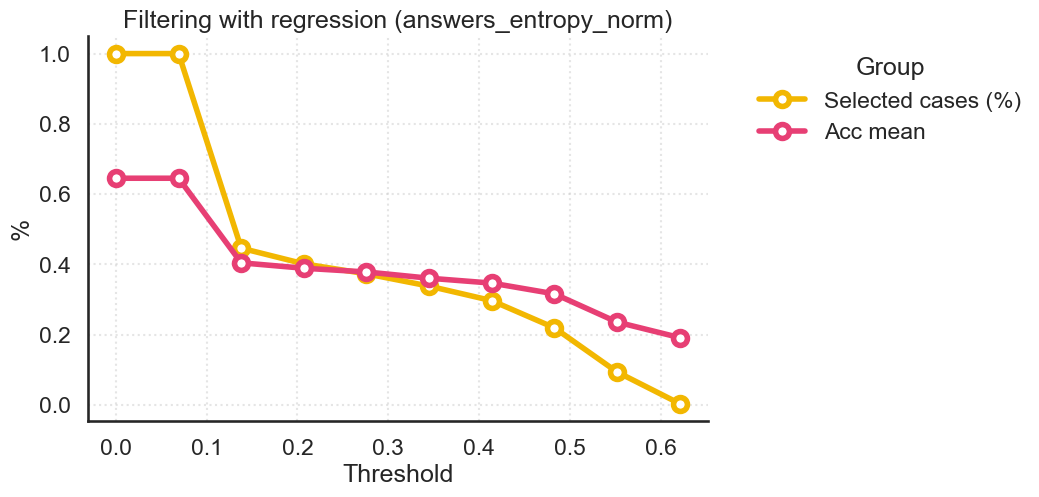

In [35]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [correct_mean[pred>=thr].mean() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc mean", marker="o", color=palette[4], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[4])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

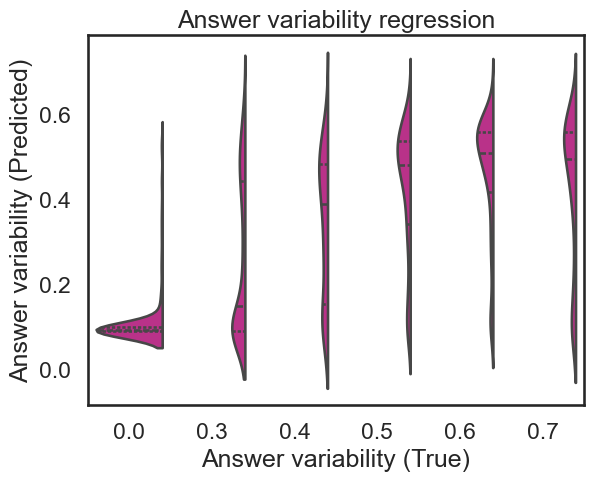

In [36]:
ax = sns.violinplot(y=pred, x=np.round(y_res.values,1), 
                    split=True, inner="quart", width=0.8, color=palette[8]) # , log_scale=(True,False))


plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [43]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

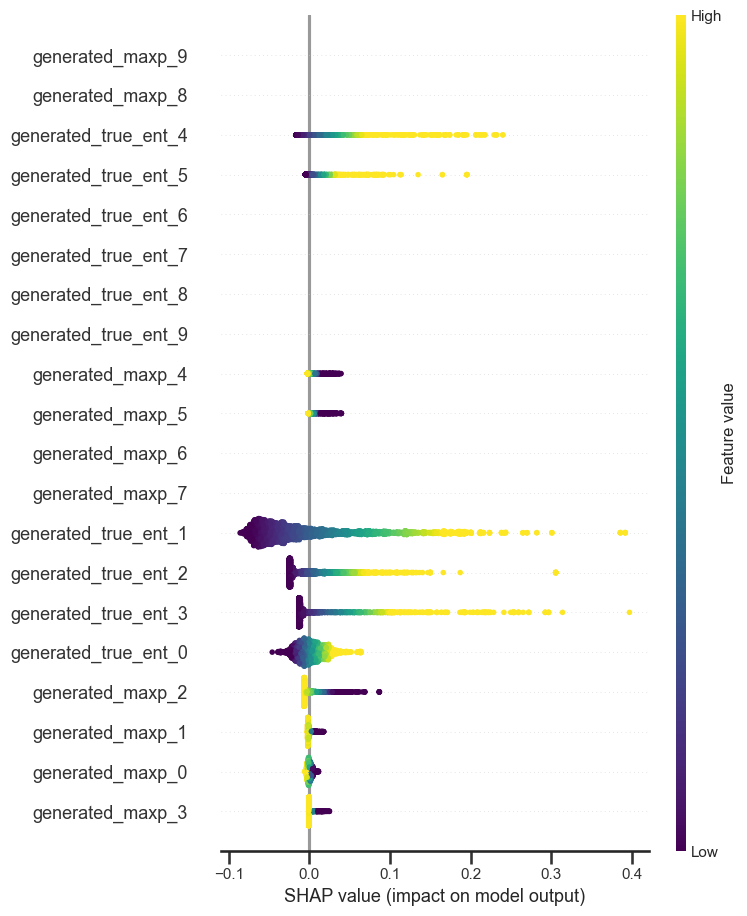

In [44]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [45]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [46]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.103542
generated_true_ent_    0.896458
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

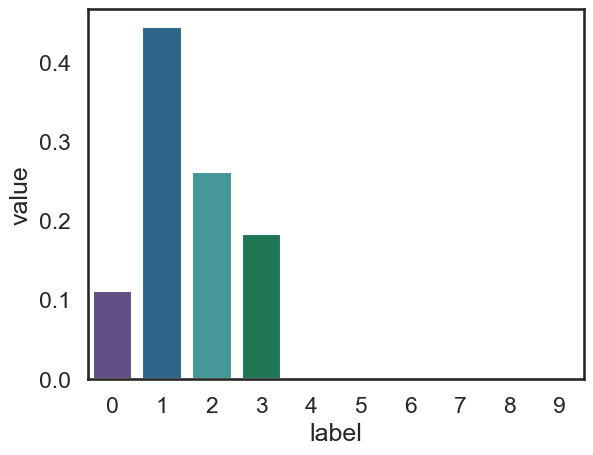

In [47]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(33.22569444444443, 0.5, 'Token index')

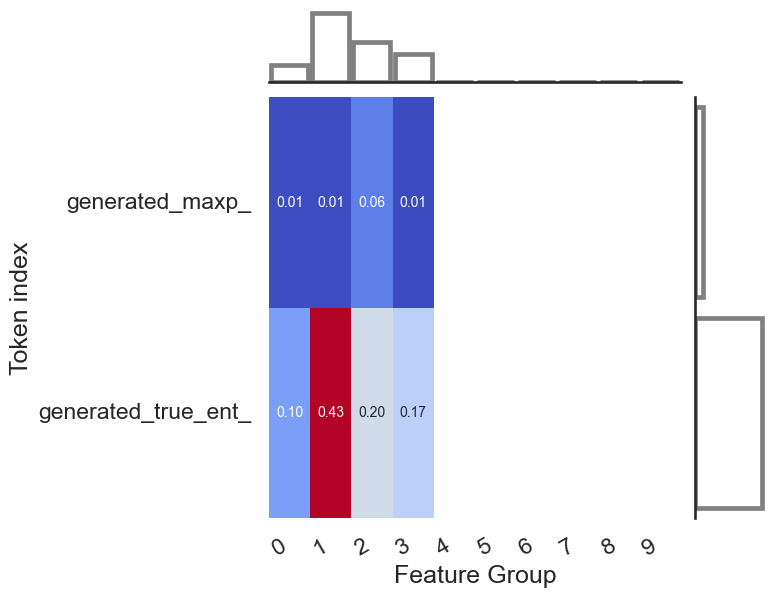

In [48]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### all features

In [49]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [50]:
X_res.shape

(5269, 430)

In [51]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 1min 25s, sys: 18.5 s, total: 1min 43s
Wall time: 21.2 s


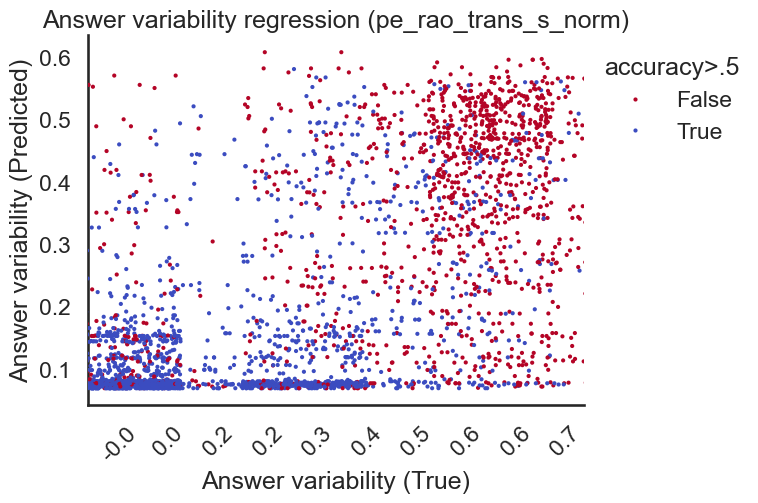

In [58]:
norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean, 
                   size=3, palette=palette) # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [59]:
met = assessme(y_res.values, pred)
met

{'mae': 0.14394268888283734,
 'mse': 0.03279179833166173,
 'rmse': 0.18108505827831772,
 'r2': 0.4563273227686987,
 'adj_r2': 0.4562241003124178}

In [60]:
%%time

import xgboost
import shap

# model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

 95%|=================== | 4991/5269 [00:12<00:00]       

CPU times: user 23.6 s, sys: 3.95 s, total: 27.5 s
Wall time: 15 s


In [61]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

grp
generated_logitlens_kl_    0.717050
generated_maxp_            0.153810
generated_true_ent_        0.129139
Name: value, dtype: float64

Text(33.22569444444443, 0.5, 'Token index')

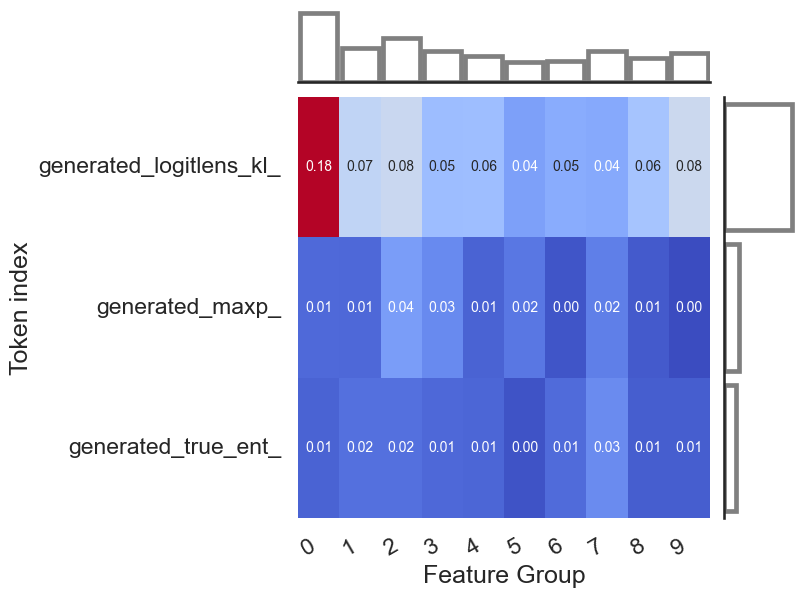

In [62]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl

In [77]:
# beginning of generation
N = 10

# selected_features = ['true_ent', 'maxp'] # + list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)
selected_features = list(df_logitlens_kl_expanded.columns)

#selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [78]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 1min 29s, sys: 20.8 s, total: 1min 50s
Wall time: 22.6 s


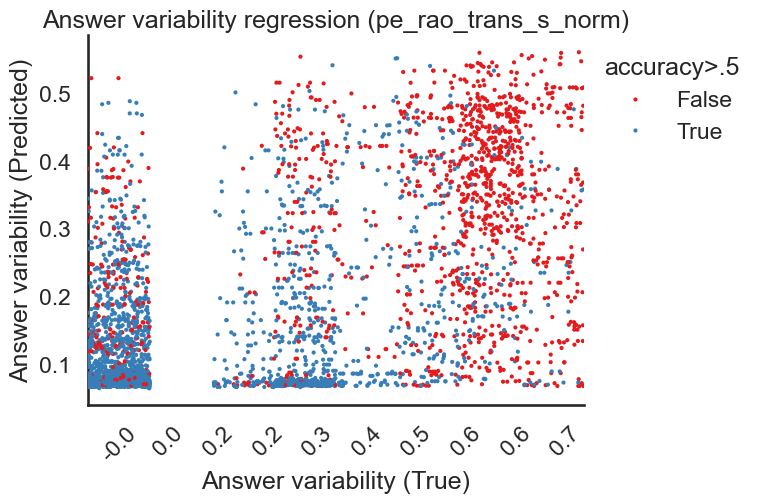

In [89]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=0.5, 
                   hue=correct_mean, 
                   size=3, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [80]:
met = assessme(y_res.values, pred)
met

{'mae': 0.15832126243536648,
 'mse': 0.038840250049513435,
 'rmse': 0.19707929888629458,
 'r2': 0.35604682258723563,
 'adj_r2': 0.3559245607346796}

invalid value encountered in scalar divide


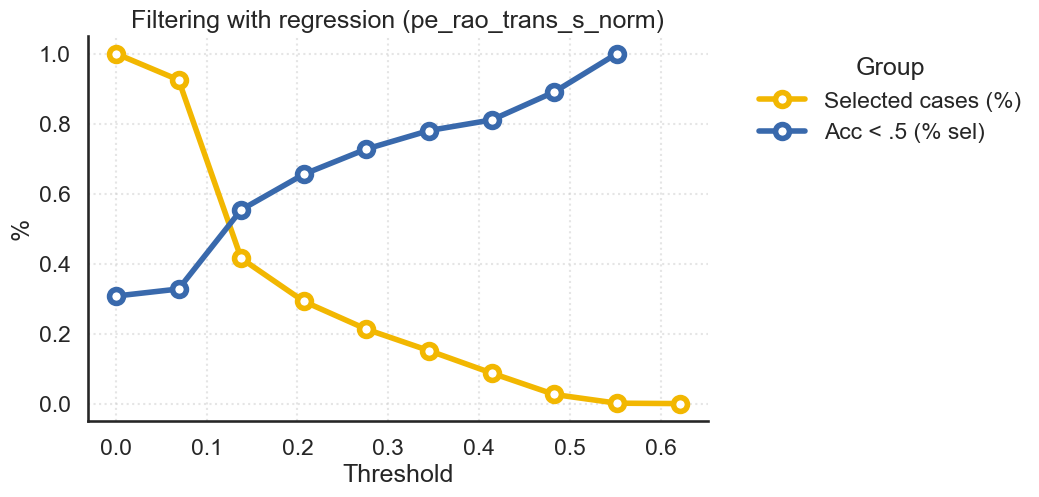

In [81]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [82]:
%%time
import xgboost
import shap

# model = xgboost.XGBRegressor(n_estimators=100, booster='gbtree', max_depth=2).fit(X_res, y_res)
model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 3.03 s, sys: 504 ms, total: 3.54 s
Wall time: 599 ms


In [83]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

# vals.groupby('grp').value.sum()

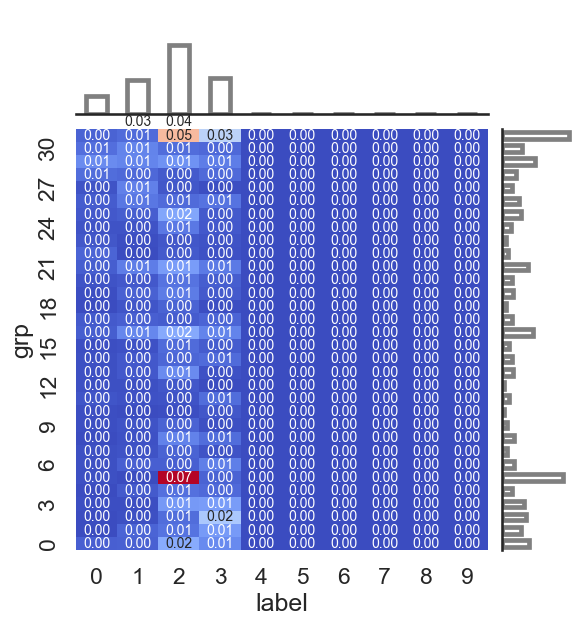

In [84]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

In [85]:
# besties
list(vals.sort_values('value', ascending=False)[:10].label_orig)

['generated_logitlens_kl5_2',
 'generated_logitlens_kl31_2',
 'generated_logitlens_kl32_2',
 'generated_logitlens_kl31_3',
 'generated_logitlens_kl32_1',
 'generated_logitlens_kl33_1',
 'generated_logitlens_kl2_3',
 'generated_logitlens_kl36_1',
 'generated_logitlens_kl33_2',
 'generated_logitlens_kl0_2']

In [93]:
%%time

# another booster bits the dust

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 2.9 s, sys: 554 ms, total: 3.45 s
Wall time: 696 ms


In [94]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

# vals.groupby('grp').value.sum()

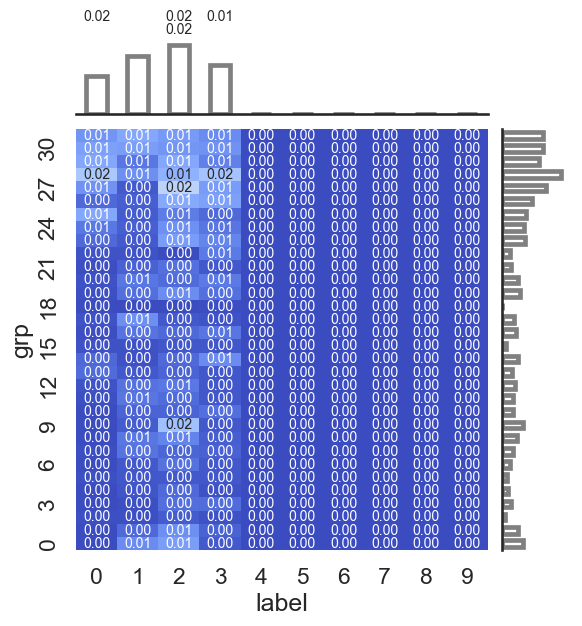

In [95]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

### only best kl features with original ones

In [130]:
# beginning of generation
N = 10

selected_features = ['maxp', 'true_ent'] + list(df_logitlens_kl_expanded.columns)


# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

besties = ['logitlens_kl36_1',
 'logitlens_kl5_2',
 'logitlens_kl28_2',
 'logitlens_kl38_1',
 'logitlens_kl28_0',
 'logitlens_kl37_3',
 'logitlens_kl30_2',
 'logitlens_kl40_2',
 'logitlens_kl6_2',
 'logitlens_kl35_2']

ds = ds[[c for c in ds.columns if c in besties or 'logitlens' not in c]]

y = ds[target].abs().round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [131]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 8.89 s, sys: 5.11 s, total: 14 s
Wall time: 3.24 s


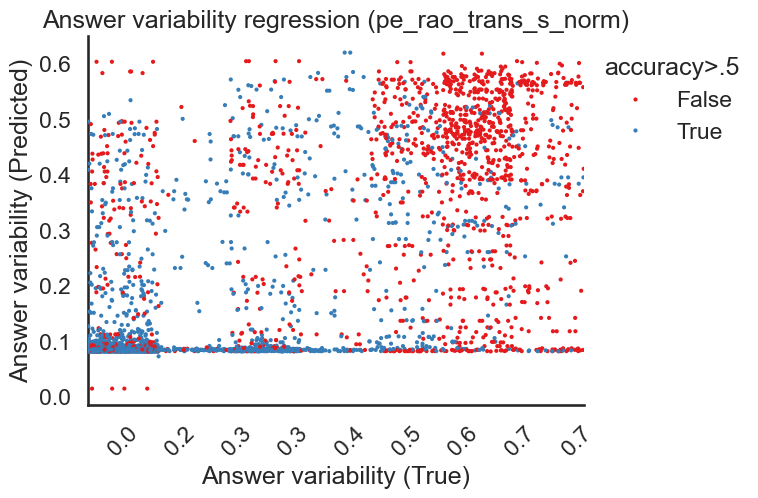

In [132]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=0.5, 
                   hue=correct_mean, 
                   size=3, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [137]:
met = assessme(y_res.values, pred)
met

{'mae': 0.14111212298995202,
 'mse': 0.032602850532585256,
 'rmse': 0.18056259450003828,
 'r2': 0.45945998889276674,
 'adj_r2': 0.4593573612088656}

invalid value encountered in scalar divide


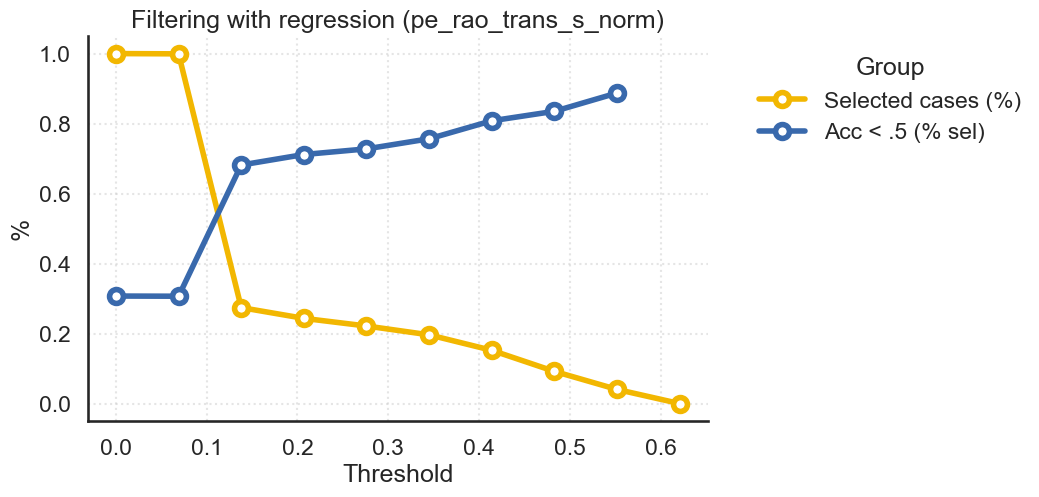

In [138]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [139]:
%%time

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

 93%|=================== | 4905/5269 [00:12<00:00]       

CPU times: user 13.5 s, sys: 1.15 s, total: 14.6 s
Wall time: 12.5 s


Text(33.22569444444443, 0.5, 'Token index')

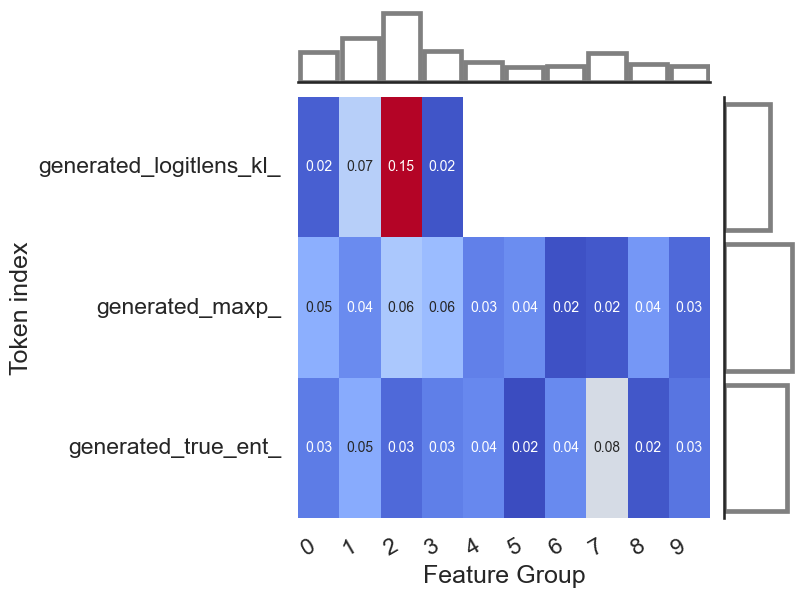

In [140]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### postilla + kl

In [141]:
# beginning of generation
selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean
correct_mean_thr = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [142]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 34.3 s, sys: 11.6 s, total: 45.9 s
Wall time: 11.4 s


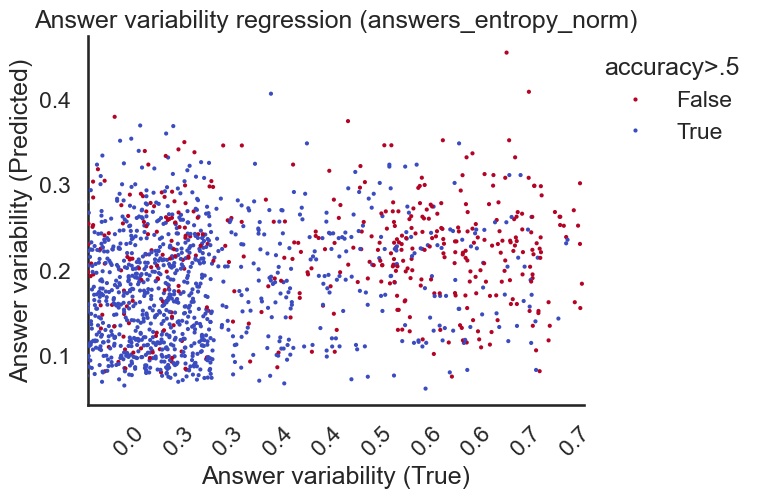

In [143]:
import matplotlib.colors as mcolors

norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean_thr, 
                   size=3, 
                   palette = palette)
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [144]:
met = assessme(y_res.values, pred)
met

{'mae': 0.22115099830745855,
 'mse': 0.061979074924233386,
 'rmse': 0.2489559698505609,
 'r2': 0.04843484124431696,
 'adj_r2': 0.0478577853566543}

invalid value encountered in scalar divide


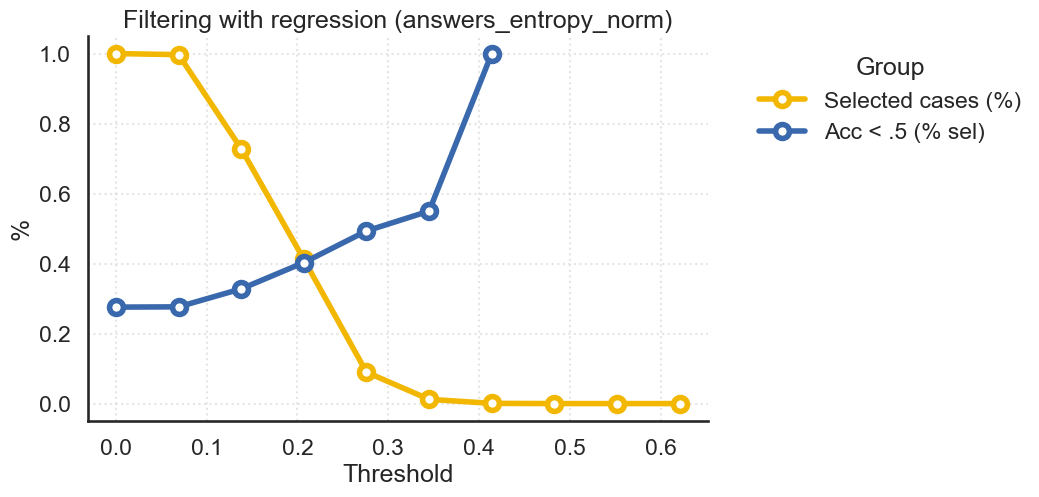

In [145]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred > thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>thr]).sum() / (pred>thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

### increasing number of cases

In [79]:
ds.pid.nunique()

1476

In [80]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

#X_res, y_res = X, y # rus.fit_resample(X, y)
#pids_res = pids # [y_res.index]

# X_res.columns = ['generated_'+col for col in X.columns]

In [81]:
group_kfold = GroupKFold(n_splits=10)

foldlist = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, pids)):
    foldlist.append(test_index)

In [82]:
# %%time

prog = []

# cycle all
for i, idxs in enumerate(foldlist):
    print(i)
    
    test_idx = idxs
    
    # cycle all, skipping i
    train_idx = set()
    c = 0
    
    # tutti gli id fuorché la fold corrente
    foldlist_ = [idxs_ for (j, idxs_) in enumerate(foldlist) if i != j]
    fold_train_idx = np.concatenate(foldlist_)
    
    # cycle all available pids
    fold_pids = pids.iloc[fold_train_idx]
    
    for pid in tqdm(fold_pids.unique()):
        
        # enlarge dataset one pid at a time
        train_idx = set(train_idx) | set(fold_train_idx[fold_pids == pid]) 
        train_idx = list(train_idx)

        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)
        xgb_model.fit(X.iloc[train_idx], y.iloc[train_idx])

        pred = xgb_model.predict(X.iloc[test_idx])
        
        # always test on out-of-fold data
        met = assessme(y.iloc[test_idx].values, pred)

        prog.append((i, c, len(train_idx), met['mae'], met['mse'], met['rmse'], met['r2']))
        c += 1
            

0


100%|███████████████████████████████████████| 1329/1329 [10:28<00:00,  2.11it/s]


1


100%|███████████████████████████████████████| 1329/1329 [05:26<00:00,  4.07it/s]


2


100%|███████████████████████████████████████| 1329/1329 [02:45<00:00,  8.01it/s]


3


100%|███████████████████████████████████████| 1329/1329 [02:16<00:00,  9.70it/s]


4


100%|███████████████████████████████████████| 1328/1328 [02:29<00:00,  8.86it/s]


5


100%|███████████████████████████████████████| 1328/1328 [01:59<00:00, 11.13it/s]


6


100%|███████████████████████████████████████| 1328/1328 [02:02<00:00, 10.81it/s]


7


100%|███████████████████████████████████████| 1328/1328 [02:01<00:00, 10.91it/s]


8


100%|███████████████████████████████████████| 1328/1328 [03:40<00:00,  6.03it/s]


9


100%|███████████████████████████████████████| 1328/1328 [05:11<00:00,  4.27it/s]


In [83]:
prog_ = pd.DataFrame(prog, columns=['i', 'c', 'n', 'mae', 'mse', 'rmse', 'r2'])

In [84]:
prog_.shape

(13284, 7)

In [85]:
prog_

,i,c,n,mae,mse,rmse,r2
0,0,0,2,0.242981,0.128171,0.358010,-0.854024
1,0,1,3,0.242981,0.128171,0.358010,-0.854024
2,0,2,4,0.242981,0.128171,0.358010,-0.854024
3,0,3,5,0.255049,0.109110,0.330318,-0.578300
4,0,4,6,0.255102,0.109017,0.330178,-0.576965
...,...,...,...,...,...,...,...
13279,9,1323,2799,0.149770,0.035929,0.189550,0.516068
13280,9,1324,2803,0.150527,0.036841,0.191939,0.503794
13281,9,1325,2804,0.148956,0.035883,0.189427,0.516698
13282,9,1326,2806,0.150525,0.036635,0.191403,0.506561


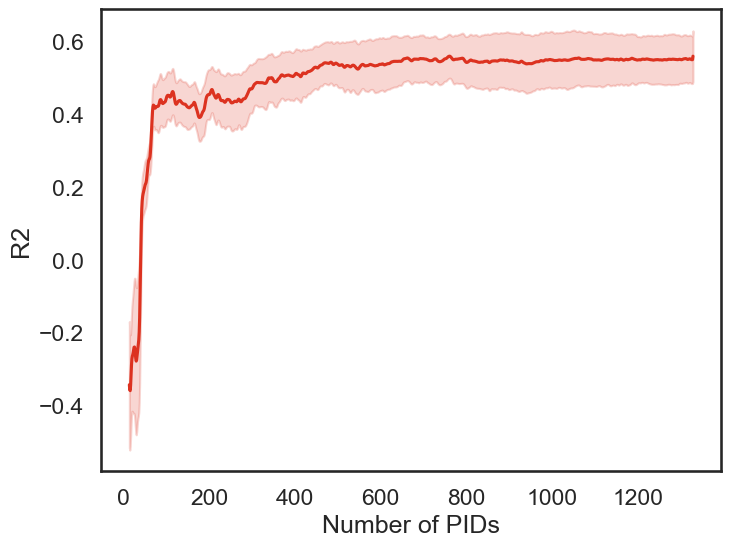

In [86]:
def smooth_data(df, column, window=10):
    return df.groupby("i")[column].transform(lambda x: x.rolling(window, win_type="gaussian").mean(std=2))

prog_["mae_smooth"] = smooth_data(prog_, "mae", window=15)
prog_["r2_smooth"] = smooth_data(prog_, "r2", window=15)

plt.figure(figsize=(8, 6))
sns.lineplot(prog_, x="c", y="r2_smooth", errorbar="sd", color='#DC3220')
# plt.title("Entropy regression MAE over number of PIDs in training")
plt.xlabel("Number of PIDs")
plt.ylabel("R2")
plt.show()

<Axes: xlabel='c', ylabel='mae'>

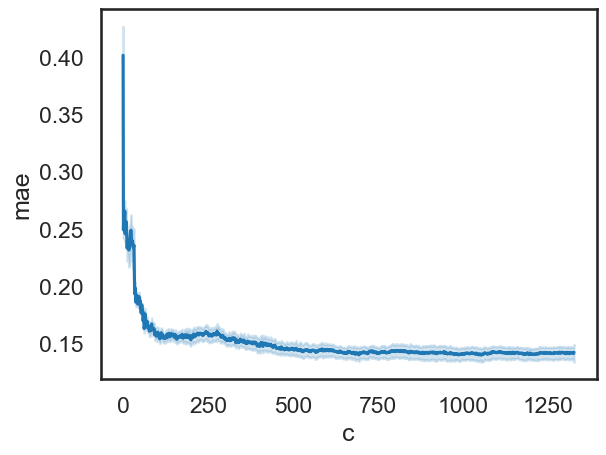

In [87]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

<Axes: xlabel='c', ylabel='mae'>

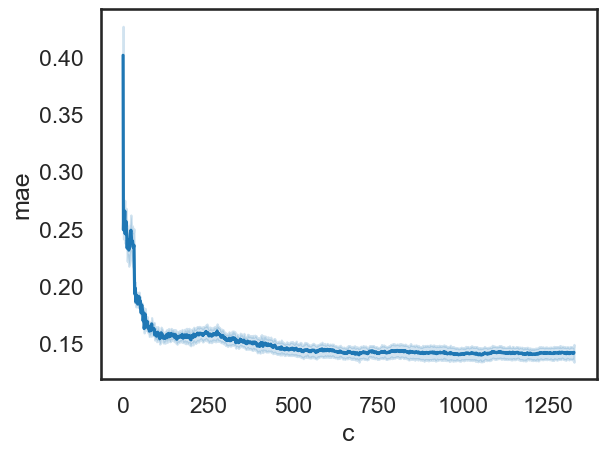

In [88]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

### beginning of generation, accuracy

In [89]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

print(ds.shape)

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

print(ds.shape)

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

X_res.shape

(14760, 26)
(3120, 26)


(3120, 20)

In [90]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, correct_mean, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 7.24 s, sys: 4 s, total: 11.2 s
Wall time: 2.76 s


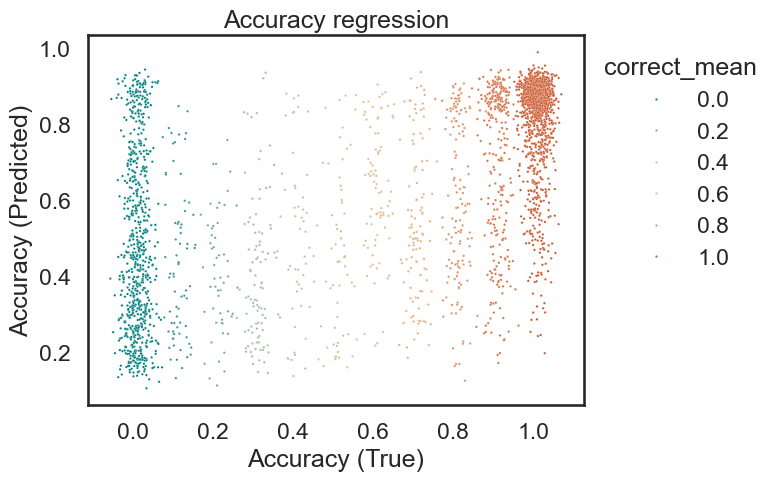

In [91]:
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.diverging import Geyser_4, Temps_6
palette = Geyser_4.get_mpl_colormap()

def jitter(values,j):
    return values + np.random.normal(j,0.02, values.shape)

ax = sns.scatterplot(y=jitter(pred,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, s=3, palette=palette)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [92]:
(correct_mean.values==1.).sum()

1395

In [93]:
met = assessme(correct_mean.values, pred)
met

{'mae': 0.2612121187690168,
 'mse': 0.11088560317160372,
 'rmse': 0.3329948996180027,
 'r2': 0.37860116589901893,
 'adj_r2': 0.37840187185344454}

In [94]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, correct_mean)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [95]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [96]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.485208
generated_true_ent_    0.514792
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

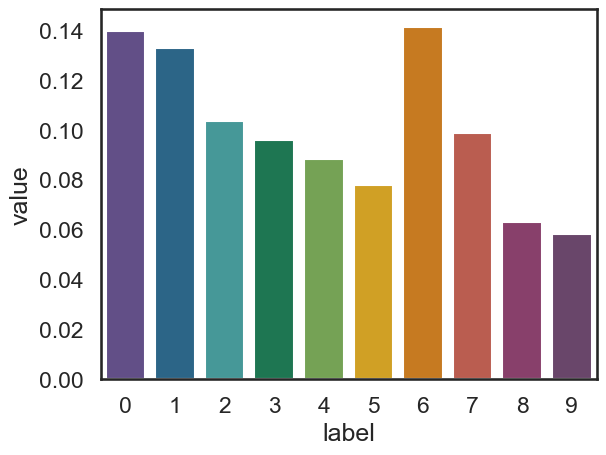

In [97]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

### postilla

In [98]:
selected_features

['true_ent', 'maxp']

In [99]:
# all postilla

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

print(ds.shape)

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

print(ds.shape)

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['postilla_'+col for col in X.columns]

X_res.shape

(14760, 120)
(1651, 120)


(1651, 114)

In [100]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 19.3 s, sys: 8.2 s, total: 27.5 s
Wall time: 6.41 s


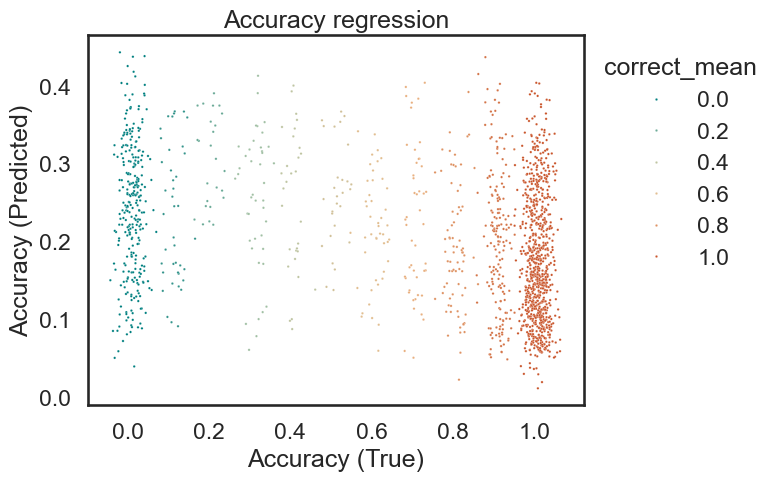

In [101]:
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.diverging import Geyser_4, Temps_6
palette = Geyser_4.get_mpl_colormap()

def jitter(values,j):
    return values + np.random.normal(j,0.02, values.shape)

ax = sns.scatterplot(y=jitter(pred_postilla,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, s=3, palette=palette)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [102]:
(correct_mean.values==1.).sum()

849

In [103]:
met = assessme(correct_mean.values, pred_postilla)
met

{'mae': 0.6137573462979207,
 'mse': 0.46002171576295764,
 'rmse': 0.6782490071964409,
 'r2': -1.9483149216393918,
 'adj_r2': -1.9501028627683423}

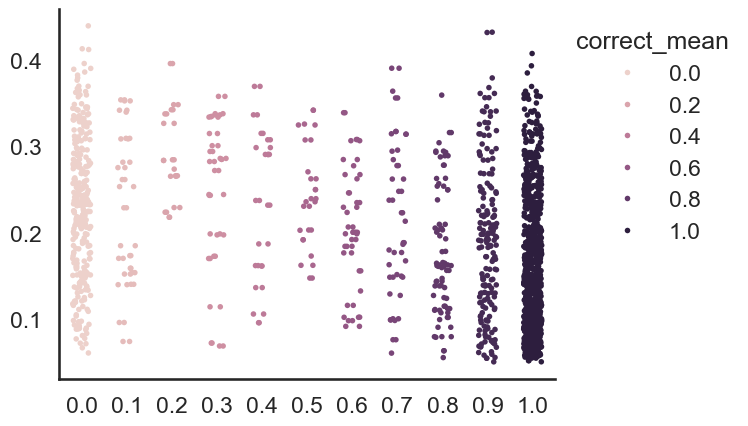

In [104]:
ax = sns.stripplot(y=pred_postilla, x=np.round(correct_mean.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

### postilla + logitlens

In [105]:
# all postilla + kl

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

print(ds.shape)

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

print(ds.shape)

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['postilla_'+col for col in X.columns]

X_res.shape

(14760, 2457)
(1651, 2457)


(1651, 2451)

In [106]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 2min 46s, sys: 44.9 s, total: 3min 31s
Wall time: 47.3 s


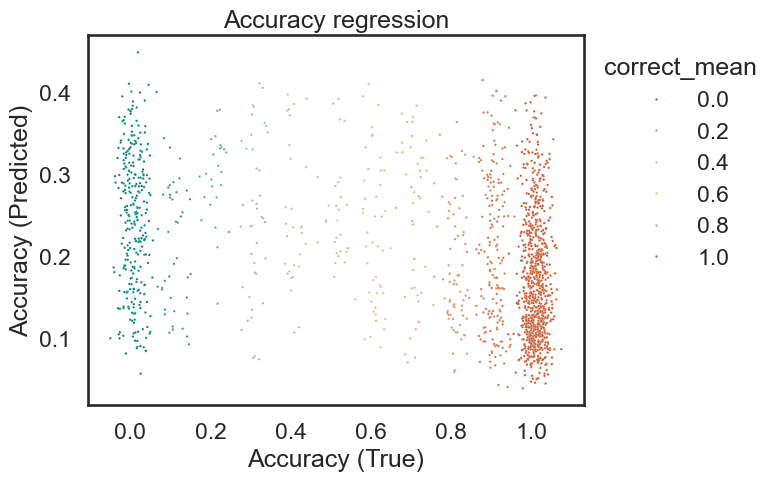

In [107]:
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.diverging import Geyser_4, Temps_6
palette = Geyser_4.get_mpl_colormap()

def jitter(values,j):
    return values + np.random.normal(j,0.02, values.shape)

ax = sns.scatterplot(y=jitter(pred_postilla,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, s=3, palette=palette)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [108]:
met = assessme(correct_mean.values, pred_postilla)
met

{'mae': 0.6162281774580118,
 'mse': 0.463715135708035,
 'rmse': 0.6809663249442185,
 'r2': -1.971986337059187,
 'adj_r2': -1.9737886332005208}